In [1]:
#Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [2]:
# Carregando o dataframe com os dados já preparados para o treinamento do modelo
%store -r df_model
df_model = df_model

In [3]:
df_model.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,H,L,M,target
0,298.1,308.6,1551.0,42.8,0,False,False,True,False
1,298.2,308.7,1408.0,46.3,3,False,True,False,False
2,298.1,308.5,1498.0,49.4,5,False,True,False,False
3,298.2,308.6,1433.0,39.5,7,False,True,False,False
4,298.2,308.7,1408.0,40.0,9,False,True,False,False


In [4]:
# Separando as variaveis de entrada (X) dos targets (Y)
X = df_model.drop(['target'], axis=1)
Y = df_model['target']

In [5]:
# Realizando a divisão da base de dados, como 30% da base sendo usada para teste e os 70% restante servindo como base de treino
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)

In [6]:
# Realizando o treinamento do modelo e árvore de decisão com os hiperparametros default do modelo
tree = DecisionTreeClassifier(random_state=42)

tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

<Axes: xlabel='score', ylabel='variaveis'>

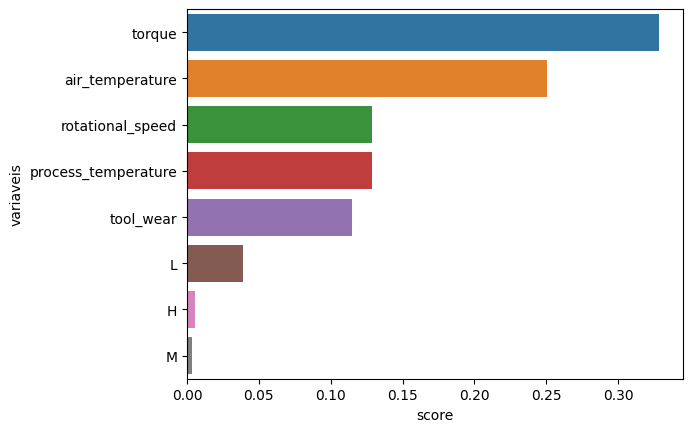

In [7]:
# Classificação da relevância das variaveis de entrada para o treinamento do modelo
dici = {'score':tree.feature_importances_, 'variaveis': X.columns}
data_ft = pd.DataFrame(dici).sort_values("score", ascending = False)
sns.barplot(data_ft, x = 'score', y = 'variaveis', orient = 'h')

In [7]:
# Calculo do desempenho do modelo utilizando AUC-ROC (Área Sob A Curva Característica de Operação do Receptor), definindo de certa uma forma uma medida de "acuracidade" para o modelo
y_proba1 = tree.predict_proba(X_test)[::,1]
test_roc_auc_1 = metrics.roc_auc_score(y_test,y_proba1)
test_roc_auc_1

0.8597434446330882

<Axes: >

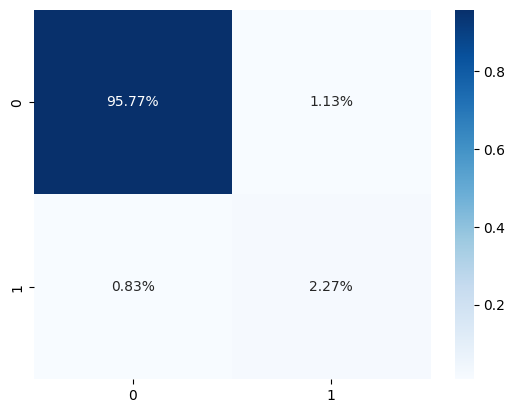

In [9]:
# Geração da matriz de confusão para checar comportamento do modelo em relação a precisão das informações
y_pred1 = tree.predict(X_test)
mt1 = metrics.confusion_matrix(y_test, y_pred1)

sns.heatmap(mt1/np.sum(mt1), annot=True, cmap='Blues', fmt='.2%')

In [10]:
# Nesse bloco, foi utilizado um otimizador de hiperparametros baseado na otimização bayesiana.
# Com isto, foi possivel buscar os melhores hiperparametros para maximizar sua acuracia.

# Filtrando avisos 
import warnings
warnings.filterwarnings('ignore')

# Importando o Bayes Search com cross-validation:
from skopt import BayesSearchCV

# Importando espaços de busca
from skopt.space import Integer

# Definindo o Random Search CV. Vamos fornecer o argumento n_iter, que fala quantas configurações de hparams testar:
bayes_search_cv = BayesSearchCV(estimator = tree,
                              search_spaces = {'max_depth':Integer(1,100), # Testando comprimentos máximos de 1 a 100
                                              'min_samples_leaf':Integer(1,100)}, # O mínimo de amostras por folha, de 1 a 100, 
                                              scoring="roc_auc", 
                              cv = 5,
                              n_iter = 100, random_state=42)

# Realizando a otimização por GridSearch para os dados:
bayes_search_cv.fit(X = X_train, y = y_train)

# Vamos ver informações relevantes:
print('Melhor comprimento maximo: {}'.format(bayes_search_cv.best_params_['max_depth']))
print('Melhor minimo de amostras por folha: {}'.format(bayes_search_cv.best_params_['min_samples_leaf']))
print('Desempenho AUC-ROC do melhor modelo: {}'.format(round(bayes_search_cv.best_score_,3)))



Melhor comprimento maximo: 80
Melhor minimo de amostras por folha: 44
Desempenho AUC-ROC do melhor modelo: 0.957


In [8]:
model_opt = DecisionTreeClassifier(random_state = 42, max_depth = 80, min_samples_leaf = 44)
model_opt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=80, min_samples_leaf=44, random_state=42)

<Axes: xlabel='score', ylabel='variaveis'>

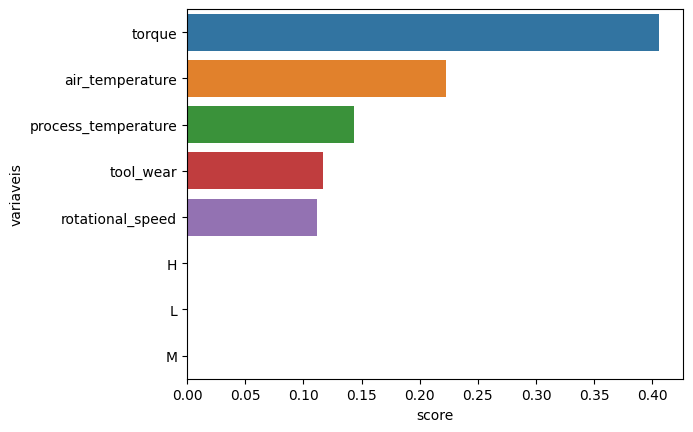

In [9]:
# Classificação da relevância das variaveis de entrada para o treinamento do modelo após a otimização bayesiana
dici = {'score':model_opt.feature_importances_, 'variaveis': X.columns}
data_ft2 = pd.DataFrame(dici).sort_values("score", ascending = False)
sns.barplot(data_ft2, x = 'score', y = 'variaveis', orient = 'h')


<Axes: >

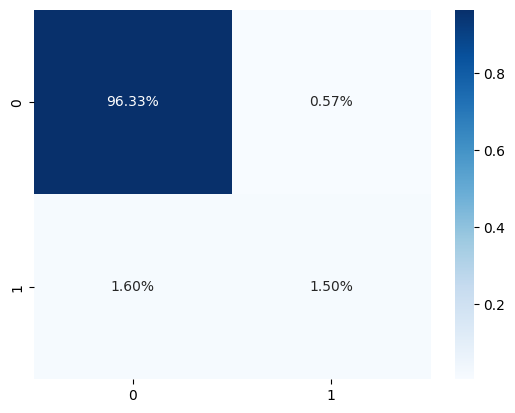

In [13]:
# Geração da matriz de confusão para checar comportamento do modelo otimizado em relação a precisão das informações
y_pred_opt = model_opt.predict(X_test)
mt2 = metrics.confusion_matrix(y_test, y_pred_opt)

sns.heatmap(mt2/np.sum(mt2), annot=True, cmap='Blues', fmt='.2%')

In [11]:
#Calculando o score da AUC-ROC para o modelo otimizado
y_proba2 = model_opt.predict_proba(X_test)[::,1]
test_roc_auc = metrics.roc_auc_score(y_test,y_proba2)
test_roc_auc

0.9575718232963812

Nota-se que as variaveis dummies criadas que representam a qualidade do produto (H = alta qualidade, M = média qualidade e L = baixa qualidade) não tiveram influencia no modelo otimizado. Pelo conhecimento da base de dados, esse comportamento pode ser considerado coerente, pois a variavel tool_wear (que representa o tempo de uso (ou desgaste) da ferramenta) é diretamente proporcional a qualidade do produto, ou seja, quanto maior a qualidade do produto, maior o desgate da ferramenta, logo é possivel inferir que são informações redundantes.

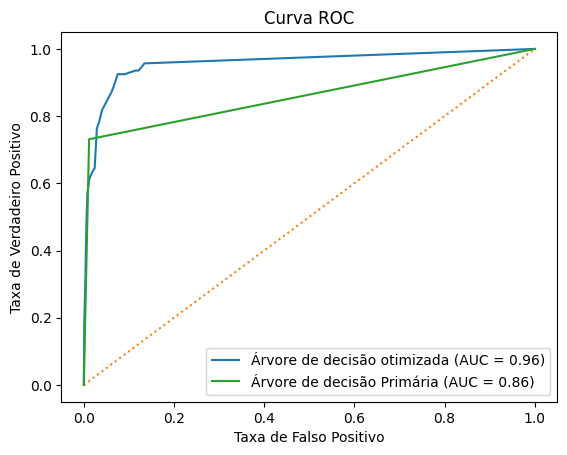

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba2)
roc_auc = metrics.roc_auc_score(y_test, y_proba2)
display_opt = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Árvore de decisão otimizada')
display_opt.plot()

fpr1, tpr1, thresholds = metrics.roc_curve(y_test, y_proba1)
roc_auc1 = metrics.roc_auc_score(y_test, y_proba1)

plt.title('Curva ROC')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.plot([0,1], [0,1], linestyle=":")
plt.plot(fpr1, tpr1, label = 'Árvore de decisão Primária (AUC = '+str(round(roc_auc1,2))+')')
plt.legend()


plt.show()

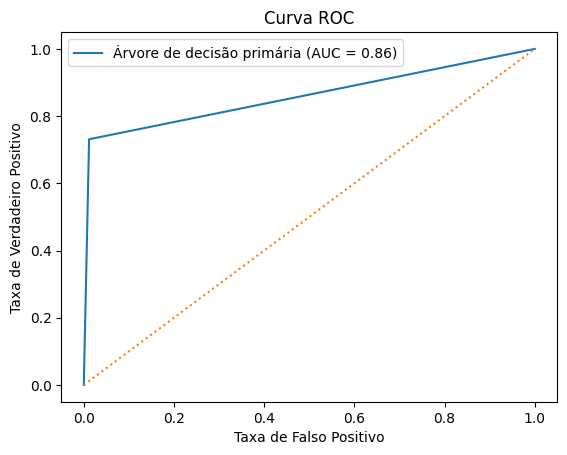

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba1)
roc_auc = metrics.roc_auc_score(y_test, y_proba1)
display_opt = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Árvore de decisão primária')
display_opt.plot()

#fpr1, tpr1, thresholds = metrics.roc_curve(y_test, y_proba1)
#roc_auc1 = metrics.roc_auc_score(y_test, y_proba1)

plt.title('Curva ROC')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.plot([0,1], [0,1], linestyle=":")
#plt.plot(fpr1, tpr1, label = 'Árvore de decisão Primária (AUC = '+str(round(roc_auc1,2))+')')
plt.legend()


plt.show()